# The Delay Time Distribution Estimators
In this notebook, we will estimate the delay time distribution of type Ia supernovae, using the separated groups of star formation histories.  


In [38]:
import os
import sys
import glob
import math
import emcee
import corner
import numpy as np
import pandas as pd
import multiprocessing
from astropy.wcs import WCS
from astropy.io import fits
import ppxf.ppxf_util as util
import ppxf.miles_util as lib
from astropy import units as u
import matplotlib.pyplot as plt
from multiprocessing import Pool
from astropy.coordinates import SkyCoord
from IPython.display import display, Math
from scipy.ndimage import gaussian_filter
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import wasserstein_distance
from astropy.wcs.utils import pixel_to_skycoord,skycoord_to_pixel
from astropy.visualization import wcsaxes,ZScaleInterval,ImageNormalize
cosmo=FlatLambdaCDM(H0=70,Om0=0.3,Tcmb0=2.725)
plt.style.use('default')

## Signal-to-Noise Ratio

In [2]:
def DER_SNR(flux):
    from numpy import array,where,median,abs,nanmedian
    flux=array(flux)
    flux=array(flux[where(flux!=0.0)])
    n=len(flux)
    if (n>4):
        signal=nanmedian(flux)
        noise=0.6052697*nanmedian(abs(2.0*flux[2:n-2]-flux[0:n-4]-flux[4:n]))
        return signal,noise
    else:return 0,100

## A Function for Multi-Thread Actions

In [3]:
def MP(taskid_lst=None,func=None,Nprocs=20):
    def worker(taskid_lst,out_q):
        outdict={}
        for tid in taskid_lst:
            outdict[tid]=func(tid)
        out_q.put(outdict)
    out_q=multiprocessing.Queue()
    chunksize = int(math.ceil(len(taskid_lst)/float(Nprocs)))
    procs=[]
    for i in range(Nprocs):
        p=multiprocessing.Process(target=worker, \
        args=(taskid_lst[chunksize*i:chunksize*(i+1)],out_q))
        procs.append(p)
        p.start()
    resultdict={}
    for i in range(Nprocs):
        resultdict.update(out_q.get())
    for p in procs:
        p.join()
    return resultdict

## Read SN Table

In [4]:
FinalSelMuse=pd.read_csv('FinalSelMuseMask3.csv',index_col=0)

## Extract Information
The following 3 cells extracts the telescope seeing and world coordinate system from the observed spectral data cube.  
These informations will be used afterwards, this step is for accelerate the program IO efficiency.  

In [5]:
def MuseExtractor(i):
    arcName=FinalSelMuse['ArcName'][i]
    crcName=arcName.replace('ADP','CDP')
    fitsFile=fits.open('../MuseObject/MuseResample/'+crcName+'.fits')
    wcsselect=WCS(fitsFile[1])
    psfSig=fitsFile[0].header['SKY_RES']/0.6/2.355
    return wcsselect,psfSig

In [6]:
museIList=[]
for i in range(len(FinalSelMuse)):
    arcName=FinalSelMuse['ArcName'][i]
    crcName=arcName.replace('ADP','CDP')
    if FinalSelMuse['SN Type'][i]!='Ia':continue
    if os.path.exists('../MuseObject/MuseResample/'+crcName+'.fits')==False:continue
    museIList.append(i)

In [7]:
MuseExtractList=MP(museIList,MuseExtractor)

## The Age-Metallicity Grid
We use a function in ppxf to make the age-metallicity grid.  
Also, we define the border between the grid points, to make it like a uniform grid in log-time space.  

In [8]:
pathname='/scratch/user/chenxingzhuo/SNHZ/ppxfSFH/ppxfGrid/EMILES_PADOVA00_BASE_KB_FITS_Sigma228/*'
velscale=60
FWHM_gal=2.76
miles=lib.miles(pathname,velscale,FWHM_gal)
ageGrid=miles.age_grid
metalGrid=miles.metal_grid
agestep=ageGrid[:,0]*10**9
ageBorder=10**np.linspace(-1.225,1.275,num=51)*10**9

## Read All the Data
Here, we read all the data that will be used in DTD estimate calculations.  
### Group Number
Firstly, you can specify the number of groups you want to separate the galaxy into, in "KNumList".  
In this example, we use 15 groups.  
Please remember to check the directory "GroupMap/", make sure there are separation maps for your specified group number for the SNe of your interest.  
Separation maps with 2 to 15 groups are included in the data set.  

### Probability Map
SN probability map here describes whether the star formation activaty in a pixel is related to the SN.  
Ideally, it is a delta function that only has value at the SN coordinate pixel.  
Here, you can specify if you want to convolve the probability map with an gaussian kernel.  
If "convloveDist" is false, then the SN probability map is convolved with the observational PSF.  
This does not mean the SN coordinate error is as large as the PSF, but when a PSF is shown on the host galaxy data, we should expect that the adjacend pixels are contaminated by the SN related stellar populations.  

### Generally Speaking
This cell reads the map of groups from "GroupMap" directory, and get (1) a list of SN coordinates, (2) the stellar mass of every groups, (3) the mass-averaged SFH of every groups, (4) the total SN probability of every groups summed by the probability map.  

In [10]:
KNumList=[15]
convolveDist=False
minposList=[]
meanSFHList=[]
massGroupList=[]
groupMapList=[]
probIndexList=[]
snNumberList=[]
count=0
for count,i in enumerate(museIList):
    wcsselect=MuseExtractList[i][0]
    if MuseExtractList[i][1]>4:continue
    if type(wcsselect) is float:continue
    snCoord=SkyCoord(FinalSelMuse['SN RA'][i]*u.deg,FinalSelMuse['SN DEC'][i]*u.deg)
    minpos=skycoord_to_pixel(snCoord,wcsselect)
    minpos=(int(minpos[0]),int(minpos[1]))
    for coreNum in KNumList:
        if os.path.exists('GroupMap/'+str(i)+'_'+FinalSelMuse['SN Name'][i]+'_'+str(coreNum)+'.fits')==False:continue
        emdFits=fits.open('GroupMap/'+str(i)+'_'+FinalSelMuse['SN Name'][i]+'_'+str(coreNum)+'.fits')
        
        try:snGroup=emdFits[0].data[minpos[1],minpos[0]]
        except:continue
        if np.isnan(snGroup):continue
        if np.sum(np.isnan(emdFits[0].data)==False)<200:continue
        
        groupMap=emdFits[0].data
        probMap=np.zeros([groupMap.shape[0],groupMap.shape[1]])
        probMap[minpos[1],minpos[0]]=1
        
        if convolveDist:
            sigmaD=MuseExtractList[i][1]**2+((10*u.kpc/cosmo.angular_diameter_distance(FinalSelMuse['Redshift'][i])).to('')*u.rad).to('arcsec').value**2
            sigmaD=sigmaD**0.5
        else:
            sigmaD=MuseExtractList[i][1]
        
        probMap=gaussian_filter(probMap,sigma=sigmaD,truncate=3)
        probIndex=np.array([np.sum(probMap[groupMap==j+1]) for j in range(coreNum)])
        mask=np.array([np.sum(groupMap==j+1)>0 for j in range(coreNum)])
        probIndex=probIndex[mask]
        
        groupMapList.append(emdFits[0].data)
        meanSFHList.append(emdFits[1].data)
        massGroupList.append(emdFits[2].data)
        minposList.append(minpos)
        probIndexList.append(probIndex)
        snNumberList.append(i)
snNumberList=np.array(snNumberList)

## MDA

In [16]:
def DTDint(tstart,tend,tau,s):
    tstartBorder=tstart.copy()
    tstartBorder[tstartBorder<tau]=tau
    tendBorder=tend.copy()
    tendBorder[tendBorder<tau]=tau
    return (tendBorder**(s+1)-tstartBorder**(s+1))/(1+s)
def ProbMapOneGal(minpos,meanSFH,groupMap,massList,probIndex,tau,s):
    massList=massList/np.sum(massList)
    dtdSeries=DTDint(ageBorder[:-1],ageBorder[1:],tau,s)
    dtdSeries=dtdSeries/np.sum(dtdSeries)
    snRateList=np.sum(meanSFH*dtdSeries,axis=1)*massList
    return np.sum(snRateList*probIndex)/np.sum(snRateList)
def LnLike(params):
    tau,s=params[0],params[1]
    tau=10**tau
    if tau<10**7.3:return -np.inf
    if tau>10**10:return -np.inf
    if s>=-0.5:return -np.inf
    if s<-6:return -np.inf
    probList=np.array([ProbMapOneGal(minposList[i],meanSFHList[i],groupMapList[i],massGroupList[i],probIndexList[i],tau,s) for i in range(len(minposList))])
    probSel=np.array([np.max(probList[snNumberList==i]) for i in set(snNumberList)])
    returner=np.sum(np.log(probSel))
    if np.isnan(returner):returner=-np.inf
    return returner


In [17]:
with Pool(12) as pool:
    ndim,nwalkers=2,36
    dtdparam=np.array([8,-1.3])+np.random.randn(nwalkers,ndim)*np.array([0.1,0.1])
    p0=dtdparam
    sampler=emcee.EnsembleSampler(nwalkers,ndim,LnLike,pool=pool)
    sampler.run_mcmc(p0,400,progress=True)

100%|██████████| 400/400 [00:23<00:00, 17.12it/s]


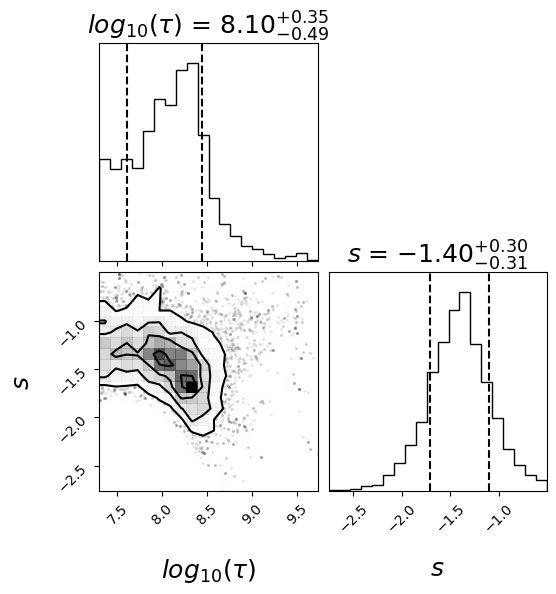

In [20]:
flat_sample=sampler.get_chain(discard=100,thin=1,flat=True)
fig=corner.corner(flat_sample,show_titles=True,quantiles=[0.16,0.84],bins=20,title_kwargs={'fontsize':18},labels=[r'$log_{10}(\tau)$',r'$s$'],label_kwargs={'fontsize':18})
fig.set_size_inches(6,6)

## MDB

In [23]:
def DTDint(tstart,tend,tau,s1,s2,tc):
    A=1
    B=A*tc**(s1-s2)
    tstartBorder=tstart.copy()
    tstartBorder[tstartBorder<tau]=tau
    tstartBorder[tstartBorder>tc]=tc
    tendBorder=tend.copy()
    tendBorder[tendBorder<tau]=tau
    tendBorder[tendBorder>tc]=tc
    
    Apart=(tendBorder**(s1+1)-tstartBorder**(s1+1))*A/(1+s1)
    Apart=np.abs(Apart)
    tstartBorder=tstart.copy()
    tstartBorder[tstartBorder<tc]=tc
    tendBorder=tend.copy()
    tendBorder[tendBorder<tc]=tc
    Bpart=(tendBorder**(s2+1)-tstartBorder**(s2+1))*B/(1+s2)
    Bpart=np.abs(Bpart)
    return Apart+Bpart
def ProbMapOneGal(minpos,meanSFH,groupMap,massList,probIndex,tau,s1,s2,tc):
    massList=massList/np.sum(massList)
    dtdSeries=DTDint(ageBorder[:-1],ageBorder[1:],tau,s1,s2,tc)
    dtdSeries=dtdSeries/np.sum(dtdSeries)
    snRateList=np.sum(meanSFH*dtdSeries,axis=1)*massList
    return np.sum(snRateList*probIndex)/np.sum(snRateList)
def LnLike(params):
    tau,s1,s2,tc=params[0],params[1],params[2],params[3]
    tau=10**tau
    tc=10**tc
    if tau<10**7.3:return -np.inf
    if tau>10**9:return -np.inf
    if tc<10**9:return -np.inf
    if tc>10**10.5:return -np.inf
    if s1>0:return -np.inf
    if s1<-6:return -np.inf
    if s2>0:return -np.inf
    if s2<-6:return -np.inf
    
    probList=np.array([ProbMapOneGal(minposList[i],meanSFHList[i],groupMapList[i],massGroupList[i],probIndexList[i],tau,s1,s2,tc) for i in range(len(minposList))])
    probSel=np.array([np.max(probList[snNumberList==i]) for i in set(snNumberList)])
    returner=np.sum(np.log(probSel))
    if np.isnan(returner):returner=-np.inf
    return returner

In [25]:
with Pool(12) as pool:
    ndim,nwalkers=4,36
    dtdparam=np.array([8,-0.3,-1.3,9.5])+np.random.randn(nwalkers,ndim)*np.array([0.1,0.1,0.1,0.1])
    p0=dtdparam
    sampler=emcee.EnsembleSampler(nwalkers,ndim,LnLike,pool=pool)
    sampler.run_mcmc(p0,400,progress=True)

100%|██████████| 400/400 [00:25<00:00, 15.57it/s]


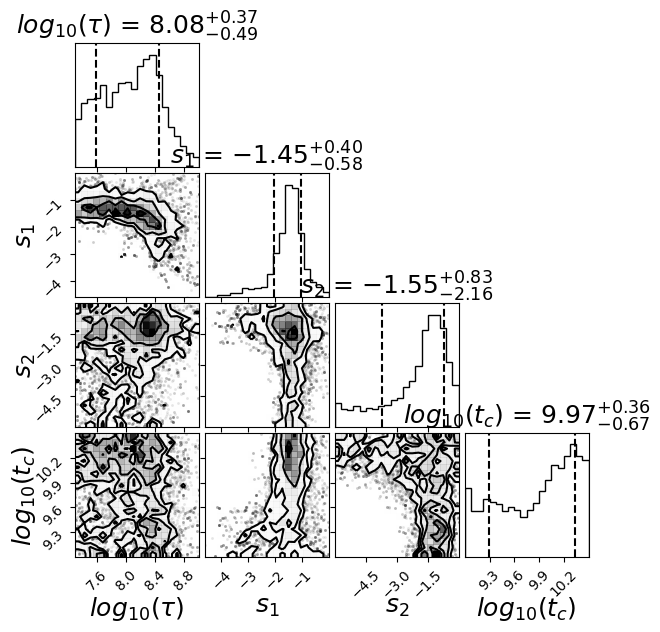

In [27]:
flat_sample=sampler.get_chain(discard=100,thin=1,flat=True)
fig=corner.corner(flat_sample,show_titles=True,quantiles=[0.16,0.84],bins=20,title_kwargs={'fontsize':18},labels=[r'$log_{10}(\tau)$',r'$s_1$',r'$s_2$',r'$log_{10}(t_c)$'],label_kwargs={'fontsize':18})
fig.set_size_inches(6,6)

## MDC

In [28]:
def DTDint(tstart,tend,tau,s,ratio,tc):
    A=1
    B=A*ratio#Well, that is different from the A and B used in the paper. 
    tstartBorder=tstart.copy()
    tstartBorder[tstartBorder<tau]=tau
    tstartBorder[tstartBorder>tc]=tc
    
    tendBorder=tend.copy()
    tendBorder[tendBorder<tau]=tau
    tendBorder[tendBorder>tc]=tc
    Apart=(tendBorder**(s+1)-tstartBorder**(s+1))*A/(1+s)
    
    tstartBorder=tstart.copy()
    tstartBorder[tstartBorder<tc]=tc
    tendBorder=tend.copy()
    tendBorder[tendBorder<tc]=tc    
    Bpart=(tendBorder**(s+1)-tstartBorder**(s+1))*B/(1+s)
    return Apart+Bpart
def ProbMapOneGal(minpos,meanSFH,groupMap,massList,probIndex,tau,s,ratio,tc):
    massList=massList/np.sum(massList)
    dtdSeries=DTDint(ageBorder[:-1],ageBorder[1:],tau,s,ratio,tc)
    dtdSeries=dtdSeries/np.sum(dtdSeries)
    snRateList=np.sum(meanSFH*dtdSeries,axis=1)*massList
    return np.sum(snRateList*probIndex)/np.sum(snRateList)
def LnLike(params):
    tau,s,ratio,tc=params[0],params[1],params[2],params[3]
    tau=10**tau
    tc=10**tc
    ratio=10**ratio
    if tau<10**7.3:return -np.inf
    if tau>10**9:return -np.inf
    if tc<10**9:return -np.inf
    if tc>10**10.5:return -np.inf
    if s<-6:return -np.inf
    if s>0:return -np.inf
    if ratio>1000:return -np.inf
    if ratio<10**-3:return -np.inf
    probList=np.array([ProbMapOneGal(minposList[i],meanSFHList[i],groupMapList[i],massGroupList[i],probIndexList[i],tau,s,ratio,tc) for i in range(len(minposList))])
    probSel=np.array([np.max(probList[snNumberList==i]) for i in set(snNumberList)])
    returner=np.sum(np.log(probSel))
    if np.isnan(returner):returner=-np.inf
    return returner

In [29]:
with Pool(12) as pool:
    ndim,nwalkers=4,36
    dtdparam=np.array([8,-1.3,0.5,9.5])+np.random.randn(nwalkers,ndim)*np.array([0.1,0.1,0.1,0.1])
    p0=dtdparam
    sampler=emcee.EnsembleSampler(nwalkers,ndim,LnLike,pool=pool)
    sampler.run_mcmc(p0,400,progress=True)

100%|██████████| 400/400 [00:26<00:00, 15.35it/s]


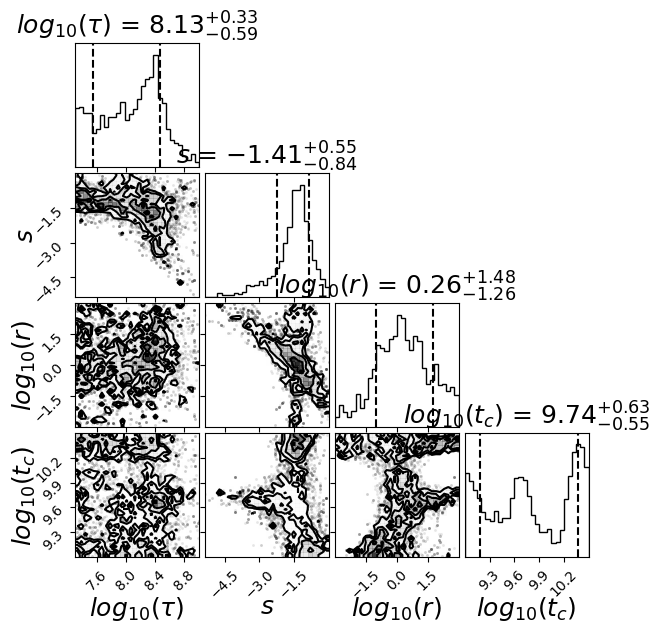

In [32]:
flat_sample=sampler.get_chain(discard=100,thin=1,flat=True)
fig=corner.corner(flat_sample,show_titles=True,quantiles=[0.16,0.84],bins=30,title_kwargs={'fontsize':18},labels=[r'$log_{10}(\tau)$',r'$s$',r'$log_{10}(r)$',r'$log_{10}(t_c)$'],label_kwargs={'fontsize':18})
fig.set_size_inches(6,6)

## MDD

In [34]:
def DTDint(tstart,tend,tau,s1,s2,ratio,tc):
    A=1
    B=ratio*A*tc**s1/tc**s2
    tstartBorder=tstart.copy()
    tstartBorder[tstartBorder<tau]=tau
    tstartBorder[tstartBorder>tc]=tc
    
    tendBorder=tend.copy()
    tendBorder[tendBorder<tau]=tau
    tendBorder[tendBorder>tc]=tc
    Apart=(tendBorder**(s1+1)-tstartBorder**(s1+1))*A/(1+s1)
    
    tstartBorder=tstart.copy()
    tstartBorder[tstartBorder<tc]=tc
    tendBorder=tend.copy()
    tendBorder[tendBorder<tc]=tc    
    Bpart=(tendBorder**(s2+1)-tstartBorder**(s2+1))*B/(1+s2)
    return Apart+Bpart
def ProbMapOneGal(minpos,meanSFH,groupMap,massList,probIndex,tau,s1,s2,ratio,tc):
    massList=massList/np.sum(massList)
    dtdSeries=DTDint(ageBorder[:-1],ageBorder[1:],tau,s1,s2,ratio,tc)
    dtdSeries=dtdSeries/np.sum(dtdSeries)
    snRateList=np.sum(meanSFH*dtdSeries,axis=1)*massList
    return np.sum(snRateList*probIndex)/np.sum(snRateList)
def LnLike(params):
    tau,s1,s2,ratio,tc=params[0],params[1],params[2],params[3],params[4]
    ratio=10**ratio
    tau=10**tau
    tc=10**tc
    if tau<10**7.3:return -np.inf
    if tau>10**9:return -np.inf
    if tc<10**9:return -np.inf
    if tc>10**10.5:return -np.inf
    if s1<-6:return -np.inf
    if s1>0:return -np.inf
    if s2<-6:return -np.inf
    if s2>0:return -np.inf
    if ratio>1000:return -np.inf
    if ratio<0.001:return -np.inf
    probList=np.array([ProbMapOneGal(minposList[i],meanSFHList[i],groupMapList[i],massGroupList[i],probIndexList[i],tau,s1,s2,ratio,tc) for i in range(len(minposList))])
    probSel=np.array([np.max(probList[snNumberList==i]) for i in set(snNumberList)])
    returner=np.sum(np.log(probSel))
    if np.isnan(returner):returner=-np.inf
    return returner

In [35]:
with Pool(12) as pool:
    ndim,nwalkers=5,36
    dtdparam=np.array([8,-1.3,-1.2,0.5,9.5])+np.random.randn(nwalkers,ndim)*np.array([0.1,0.1,0.1,0.1,0.1])
    p0=dtdparam
    sampler=emcee.EnsembleSampler(nwalkers,ndim,LnLike,pool=pool)
    sampler.run_mcmc(p0,400,progress=True)

100%|██████████| 400/400 [00:22<00:00, 17.65it/s]


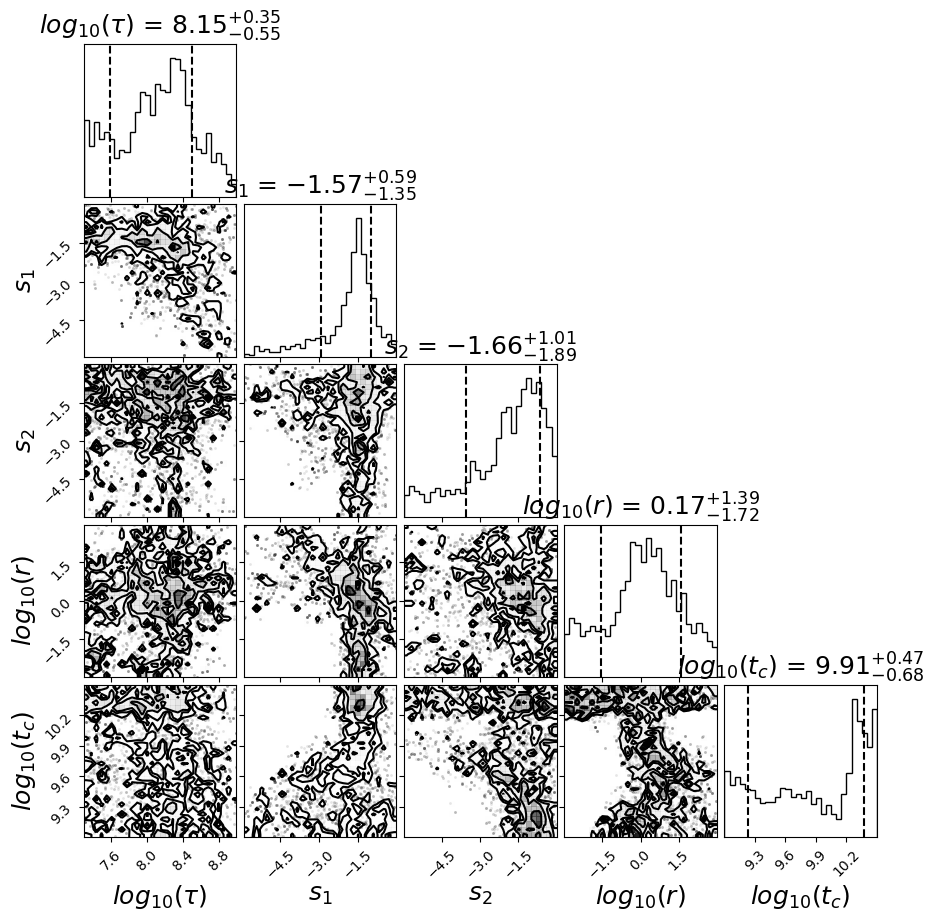

In [37]:
flat_sample=sampler.get_chain(discard=100,thin=1,flat=True)
fig=corner.corner(flat_sample,show_titles=True,quantiles=[0.16,0.84],bins=30,title_kwargs={'fontsize':18},labels=[r'$log_{10}(\tau)$',r'$s_1$',r'$s_2$',r'$log_{10}(r)$',r'$log_{10}(t_c)$'],label_kwargs={'fontsize':18})
fig.set_size_inches(9,9)